# Hackathon
Manuel Nuetzi

25770936

manuelhans.nuetzi@student.uts.edu.au

## Regime Aware Hierarchical Risk Parity with a walk forward RF regime classifier

### Project purpose
I built a regime-aware portfolio that flips between risk-on and risk-off based on a learned view of next month’s market risk. I use Hierarchical Risk Parity for allocation so diversification and drawdown control stay front and center. All inputs come from Yahoo Finance via `yfinance` and are price-based.

### Overview of the approach
**ML with walk-forward training.** I train a Random Forest that predicts whether the next month will be high risk or low risk. The features include the VIX level and its term structure using VIX and VIX3M, SPY momentum, a credit spread proxy using HYG minus LQD, and the yield curve slope using TNX minus IRX.

Labels tag months in the top 30 percent of realized SPY volatility. The model is trained in an expanding walk-forward setup with hyperparameters tuned by cross-validation on the training slice only and then refit on a regular schedule. Probabilities are calibrated on a short trailing window of the training data. All features are lagged by one month so the decision at time *t* only uses information that was available before *t*. I smooth the predicted probabilities and use hysteresis: enter high risk when the probability is at least **0.65** and exit only when it falls below **0.35**. This simple rule cuts down on whipsaw.

**Risk estimation and allocation per regime.** Covariance is made robust: **Ledoit–Wolf shrinkage is applied in both regimes**; in high risk the correlation input switches to **Spearman** (vs. Pearson in low risk). HRP weights include a small minimum per asset, with gentle smoothing toward last month’s weights to keep turnover in check. The portfolio targets about **10%** annual volatility in low risk and about **5%** in high risk. Exposure in high risk is capped at **50%** so the remainder sits in cash. Two extra safeguards are in place: when average absolute correlation spikes, exposure tightens, and when a broad equal-weight basket is already in drawdown, an additional cap applies for the next month.

### Data handling
I download daily data, lightly forward-fill holidays, align everything to month-end for decisions and trades, and guard against missing values. Evaluation and plots are out-of-sample only. They start at the first month where the walk-forward model produces a prediction that can be realized in the following month.

### Portfolios I build
1. Regime-Aware HRP which switches between the risk-on and risk-off universes  
2. HRP on the full universe without regimes  
3. Equal Weight across all assets

### Backtest and reporting
I rebalance monthly with transaction costs and I account for turnover. I report an out-of-sample performance table, out-of-sample cumulative returns, out-of-sample drawdowns, turnover diagnostics, and a regime probability timeline.

### Libraries
`yfinance`, `pandas`, `numpy`, `scikit-learn`, `scipy`, `matplotlib`, `missingno`


Imports and setup.


In [1]:
import warnings, sys, math
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt


pd.set_option('display.float_format', lambda x: f"{x:,.6f}")
RNG_SEED = 42
np.random.seed(RNG_SEED)


Parameters and universes.


In [ ]:
# Parameters
START_DATE = '2000-01-01'      # Start of data history
END_DATE   = '2025-09-01'      # End of data history
REBAL_FREQ = 'M'               # Monthly rebalancing
COV_LOOKBACK_DAYS = 252        # Window for covariance estimation (daily data)
TRANS_COST_BPS = 5             # 5 bps per trade (one-way)
RISK_PROB_ENTER = 0.65   # enter high-risk (risk-off) when prob ≥ this
RISK_PROB_EXIT  = 0.35   # exit high-risk when prob < this

# Portfolio universes
RISK_ON  = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'HYG']
RISK_OFF = ['TLT', 'LQD', 'GLD', 'SHY']
  
# Feature tickers (market‑wide signals)
FEATURE_TICKS = {
    'SPY': 'SPY',             # equity proxy for realized vol & momentum
    'VIX': '^VIX',            # implied vol index
    'VIX3M': '^VIX3M',        # VIX 3‑month (term structure)
    'TNX': '^TNX',            # 10Y Treasury yield (CBOE)
    'IRX': '^IRX',            # 13‑week T‑Bill yield (CBOE)
    'HYG': 'HYG',             # high yield credit
    'LQD': 'LQD'              # investment grade credit
}

# Combined price universe (assets + features)
ALL_TICKS = sorted(set(RISK_ON + RISK_OFF + list(FEATURE_TICKS.values())))
ALL_TICKS


['EEM',
 'EFA',
 'GLD',
 'HYG',
 'IWM',
 'LQD',
 'QQQ',
 'SHY',
 'SPY',
 'TLT',
 '^IRX',
 '^TNX',
 '^VIX',
 '^VIX3M']

Download prices, forward fill short gaps, and show a fill summary.


In [3]:
# Download Adjusted Close Prices via yfinance
FFILL_DAYS = 3  # max consecutive days to carry forward

prices = (
    yf.download(ALL_TICKS, start=START_DATE, end=END_DATE,
                auto_adjust=False, progress=False)['Adj Close']
    .sort_index()
)

# drop days where nothing traded across the entire panel
prices = prices.dropna(how='all')

# keep a copy BEFORE filling for comparison
prices_before = prices.copy()

# forward-fill short, per-ticker gaps (does NOT fill leading NaNs)
prices = prices.ffill(limit=FFILL_DAYS)

# ---------- How many cells got forward-filled per ticker ----------
ffill_mask = prices_before.isna() & prices.notna()
ffill_counts = ffill_mask.sum().sort_values(ascending=False)

# Optional: tidy summary with percentages and remaining NaNs
ffill_summary = pd.DataFrame({
    "ffill_cells": ffill_counts,
    "ffill_pct_of_days": (ffill_counts / len(prices) * 100).round(2),
    "remaining_na": prices.isna().sum().reindex(ffill_counts.index)
})

print("\nForward-filled cells per ticker (<= FFILL_DAYS runs):")
print(ffill_summary)

# Optional: how many calendar days had ANY forward-fill across the panel
days_with_any_ffill = int(ffill_mask.any(axis=1).sum())
print(f"\nDays with at least one ffilled value: {days_with_any_ffill}")



Forward-filled cells per ticker (<= FFILL_DAYS runs):
        ffill_cells  ffill_pct_of_days  remaining_na
Ticker                                              
^IRX              6           0.090000             0
^TNX              6           0.090000             0
EEM               0           0.000000           822
EFA               0           0.000000           416
GLD               0           0.000000          1226
HYG               0           0.000000          1826
IWM               0           0.000000           101
LQD               0           0.000000           644
QQQ               0           0.000000             0
SHY               0           0.000000           644
SPY               0           0.000000             0
TLT               0           0.000000           644
^VIX              0           0.000000             0
^VIX3M            0           0.000000          1642

Days with at least one ffilled value: 6


Check for missing data

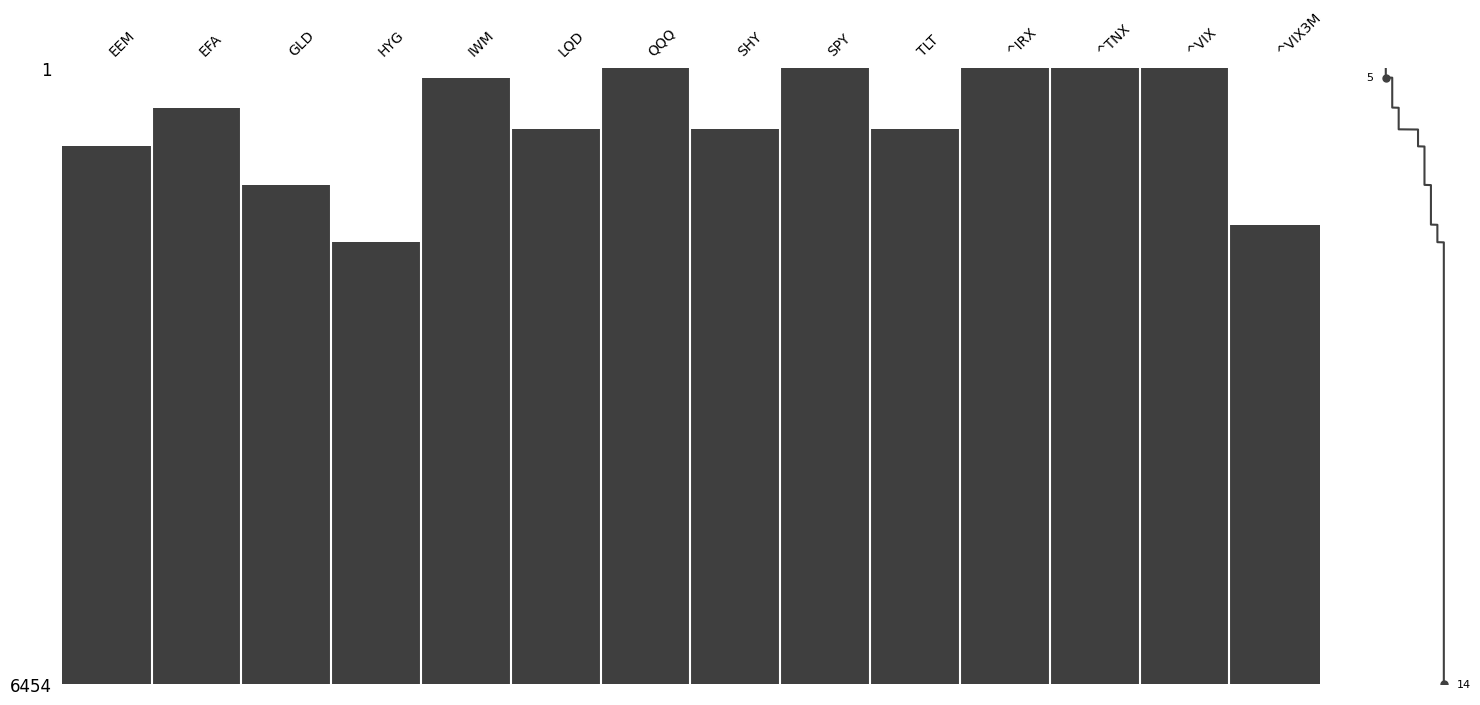

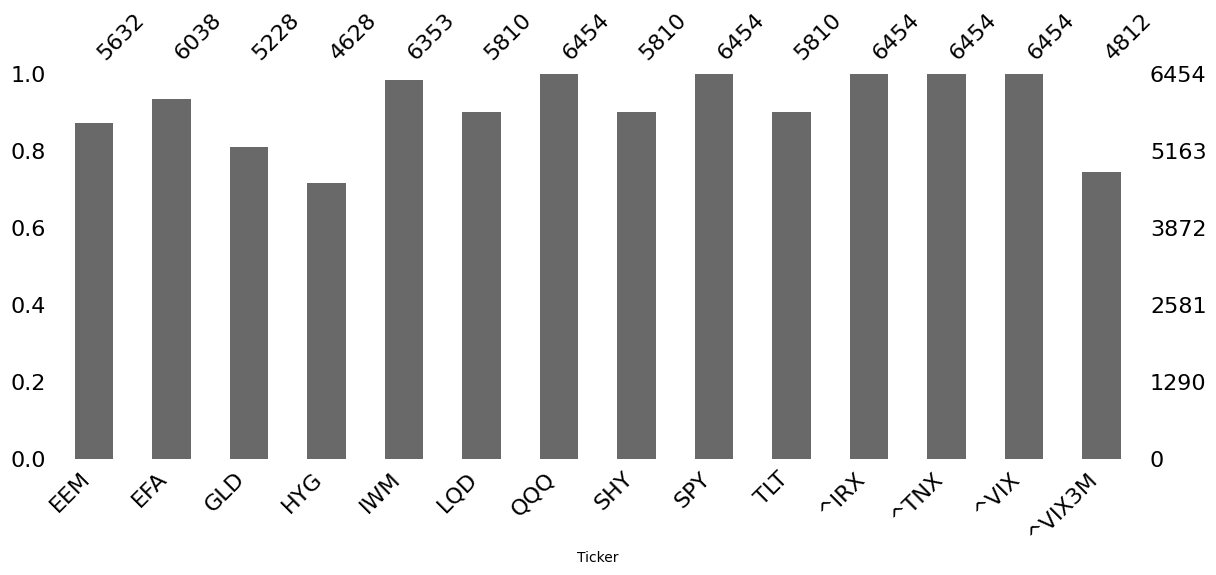

In [4]:
import missingno as msno
import matplotlib.pyplot as plt
# 2) Visuals (great for spotting long “inception” gaps)
msno.matrix(prices, figsize=(18,8), fontsize=10)
plt.show()

msno.bar(prices, figsize=(14,5))
plt.show()




Asset returns and monthly features.


In [5]:
# === Daily returns for portfolio assets ===
asset_ticks = sorted(set(RISK_ON + RISK_OFF))
asset_px = prices[asset_ticks].dropna(how='all')
asset_ret = asset_px.pct_change().dropna()

# === Feature engineering (monthly) ===
px = prices.copy()

def end_of_month(df):
    return df.resample('M').last()

px_m = end_of_month(px)

# --- replace the whole SPY realized-vol block with this ---
spy_daily = prices[FEATURE_TICKS['SPY']].dropna().pct_change()
spy_m_realvol = spy_daily.resample('M').std()    # monthly realized vol from daily returns
spy_m_realvol.name = 'SPY_RealVol'

# Construct monthly features
feat = pd.DataFrame(index=px_m.index)
feat['VIX'] = px_m[FEATURE_TICKS['VIX']]
feat['VIX3M'] = px_m.get(FEATURE_TICKS['VIX3M'])
feat['VIX_TS'] = feat['VIX3M'] / feat['VIX'] - 1
feat['TNX'] = px_m[FEATURE_TICKS['TNX']] / 100.0
feat['IRX'] = px_m[FEATURE_TICKS['IRX']] / 100.0
feat['YC_Slope'] = feat['TNX'] - feat['IRX']
hyg_m = px_m[FEATURE_TICKS['HYG']].pct_change()
lqd_m = px_m[FEATURE_TICKS['LQD']].pct_change()
feat['CreditDiff_1M'] = hyg_m - lqd_m
spy_m = px_m[FEATURE_TICKS['SPY']]
feat['SPY_Mom_1M'] = spy_m.pct_change(1)
feat['SPY_Mom_3M'] = spy_m.pct_change(3)

# Join realized vol (indexes already month-end aligned)
feat = feat.join(spy_m_realvol, how='left').dropna()


# Drop early rows with missing features
feat = feat.dropna().copy()
feat.tail()


,VIX,VIX3M,VIX_TS,TNX,IRX,YC_Slope,CreditDiff_1M,SPY_Mom_1M,SPY_Mom_3M,SPY_RealVol
Date,,,,,,,,,,
2025-04-30,24.700001,25.540001,0.034008,0.041770,0.041900,-0.000130,0.003878,-0.008670,-0.075790,0.033194
2025-05-31,18.570000,21.379999,0.151319,0.044160,0.042320,0.001840,0.015468,0.062845,-0.005077,0.010687
2025-06-30,16.730000,19.440001,0.161985,0.042300,0.041900,0.000400,-0.002439,0.051386,0.107772,0.006262
2025-07-31,16.719999,19.139999,0.144737,0.043600,0.042350,0.001250,0.002255,0.023032,0.143197,0.004132
2025-08-31,15.360000,18.350000,0.194662,0.042270,0.040430,0.001840,0.000618,0.020520,0.097672,0.007543


Labels and feature alignment.


In [6]:
# === Label: Next-month High-Risk indicator (past-only threshold) ===
# Use a past-only rolling 70th percentile for SPY realized vol.
rv = feat['SPY_RealVol'].copy()

ROLL_Q = 60  # months of history to form the percentile (min 24)
thr = rv.shift(1).rolling(ROLL_Q, min_periods=24).quantile(0.70)  # past-only

labels = pd.DataFrame(index=rv.index)
labels['HighRisk_t'] = (rv >= thr).astype(int)
labels['HighRisk_tplus1'] = labels['HighRisk_t'].shift(-1)
labels = labels.dropna().copy()

X = feat.loc[labels.index][[
    'VIX','VIX3M','VIX_TS','TNX','IRX','YC_Slope',
    'CreditDiff_1M','SPY_Mom_1M','SPY_Mom_3M','SPY_RealVol'
]].copy()
y = labels['HighRisk_tplus1'].astype(int).copy()
print('Class balance (0/1):')
print(y.value_counts(normalize=True).rename('share'))


Class balance (0/1):
HighRisk_tplus1
0   0.780822
1   0.219178
Name: share, dtype: float64


Time series split, grid search, in sample report, and feature importances.


In [7]:
# === Time-series split & Random Forest with simple grid search ===
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestClassifier(random_state=RNG_SEED, class_weight='balanced', n_jobs=-1)
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [3, 5, None],
    'min_samples_leaf': [1, 3, 5]
}
gcv = GridSearchCV(
    rf, param_grid, cv=tscv, scoring='balanced_accuracy', n_jobs=-1, verbose=0
)
gcv.fit(X, y)
best_rf = gcv.best_estimator_
print('Best CV score (balanced accuracy):', gcv.best_score_)
print('Best params:', gcv.best_params_)

# In-sample performance (for brevity; you can create a proper walk-forward later)
y_pred = best_rf.predict(X)
print('\nClassification report (in-sample):')
print(classification_report(y, y_pred, digits=3))
print('Confusion matrix:')
print(confusion_matrix(y, y_pred))

imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
imp


Best CV score (balanced accuracy): 0.5851851851851851
Best params: {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 200}

Classification report (in-sample):
              precision    recall  f1-score   support

           0      0.910     0.889     0.899       171
           1      0.635     0.688     0.660        48

    accuracy                          0.845       219
   macro avg      0.772     0.788     0.780       219
weighted avg      0.850     0.845     0.847       219

Confusion matrix:
[[152  19]
 [ 15  33]]


SPY_RealVol     0.155856
YC_Slope        0.147108
VIX             0.140953
SPY_Mom_3M      0.120891
TNX             0.106039
SPY_Mom_1M      0.080832
VIX_TS          0.077480
VIX3M           0.072213
IRX             0.051720
CreditDiff_1M   0.046908
dtype: float64

Feature importance plot.


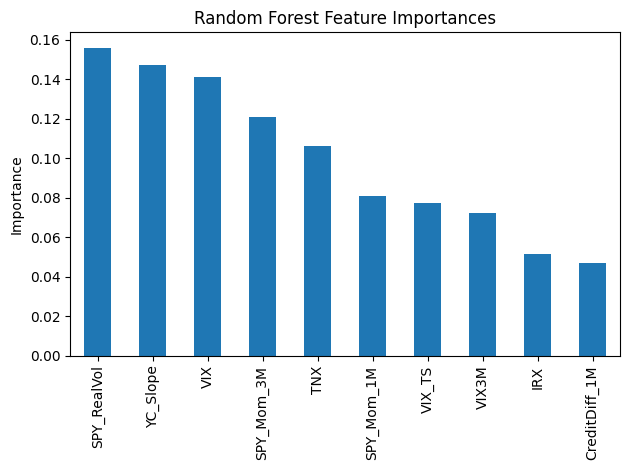

In [8]:
# === Plot feature importances ===
ax = imp.plot(kind='bar')
ax.set_title('Random Forest Feature Importances')
ax.set_ylabel('Importance')
plt.tight_layout()
plt.show()


Walkforward Function

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

def walkforward_predict_proba(X, y, param_grid, min_train=60, refit_every=12,
                              calibrate=True, cal_window=24, random_state=42):
    """
    Expanding-window walk-forward predictions.
    At month t, train ONLY on data up to t-1, tune hyperparams on TRAINING slice via CV,
    optionally calibrate on the most-recent training window, then predict Pr(high-risk) at t.
    """
    idx = X.index
    proba = pd.Series(index=idx, dtype=float)
    best_params, last_refit = None, -10**9

    for i in range(min_train, len(idx)-1):
        t = idx[i]            # decision at t (weights applied for next month t+1)
        # Refit params every 'refit_every' months
        if (i - last_refit) >= refit_every or best_params is None:
            last_refit = i
            # TRAINING slice strictly before t
            X_tr = X.iloc[:i]
            y_tr = y.iloc[:i]
            # If only one class in training, fallback to base-rate model
            if y_tr.nunique() < 2:
                base_rate = float(y_tr.mean())
                best_params = None
                # Predict base rate from t onward until we have 2 classes again
                proba.loc[t] = base_rate
                continue
            # CV only on training data
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
            base = RandomForestClassifier(n_estimators=200, random_state=random_state, n_jobs=-1)
            gs = GridSearchCV(base, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
            gs.fit(X_tr, y_tr)
            best_params = gs.best_params_

        # Build the model at current t with best params on all training data
        X_tr = X.iloc[:i]
        y_tr = y.iloc[:i]
        has_two = (y_tr.nunique() >= 2)
        if not has_two:
            proba.loc[t] = float(y_tr.mean())
            continue

        rf = RandomForestClassifier(random_state=random_state, n_jobs=-1, **best_params)
        if calibrate and len(X_tr) >= max(min_train, cal_window+min_train//2):
            # calibrate using a trailing window from training only
            X_cal = X_tr.iloc[-cal_window:] if len(X_tr) > cal_window else X_tr
            y_cal = y_tr.iloc[-cal_window:] if len(y_tr) > cal_window else y_tr
            # if trailing window is single-class, expand to full training
            if y_cal.nunique() < 2:
                X_cal, y_cal = X_tr, y_tr
            # fit base model on remainder of training (excluding cal window)
            n_excl = len(X_cal)
            X_fit = X_tr.iloc[:-n_excl] if n_excl < len(X_tr) else X_tr
            y_fit = y_tr.iloc[:-n_excl] if n_excl < len(y_tr) else y_tr
            if y_fit.nunique() < 2:
                X_fit, y_fit = X_tr, y_tr
            rf.fit(X_fit, y_fit)
            clf = CalibratedClassifierCV(rf, cv="prefit", method="sigmoid")
            clf.fit(X_cal, y_cal)
            p = clf.predict_proba(X.loc[[t]])[0, 1]
        else:
            rf.fit(X_tr, y_tr)
            p = rf.predict_proba(X.loc[[t]])[0, 1]

        proba.loc[t] = p

    return proba.dropna()

HRP utilities.


In [10]:
# === HRP implementation utilities ===
def correl_dist(corr):
    # distance matrix from correlation: d = sqrt(0.5*(1 - corr))
    return ((1 - corr) / 2.0) ** 0.5

def get_quasi_diag(link):
    # seriation (quasi-diagonalization) from linkage
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0]*2, 2)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j, 0]
        df0 = pd.Series(link[j, 1], index=i+1)
        sort_ix = pd.concat([sort_ix, df0])
        sort_ix = sort_ix.sort_index()
        sort_ix.index = range(sort_ix.shape[0])
    return sort_ix.tolist()

def get_ivp(cov):
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def get_cluster_var(cov, cluster_items):
    cov_ = cov[np.ix_(cluster_items, cluster_items)]
    w_ = get_ivp(cov_)
    return np.dot(w_, np.dot(cov_, w_))

def hrp_weights(cov, corr, assets):
    # 1) tree clustering
    dist = correl_dist(corr)
    link = linkage(squareform(dist, checks=False), 'single')
    sort_ix = get_quasi_diag(link)
    assets_ix = [assets[i] for i in sort_ix]
    # 2) recursive bisection
    w = pd.Series(1.0, index=assets_ix)
    clusters = [assets_ix]
    while len(clusters) > 0:
        clusters = [i[j:k] for i in clusters for j,k in ((0, int(len(i)/2)), (int(len(i)/2), len(i))) if len(i)>1]
        for subcluster in range(0, len(clusters), 2):
            if subcluster+1 >= len(clusters):
                continue
            c_items0 = clusters[subcluster]
            c_items1 = clusters[subcluster+1]
            idx0 = [assets_ix.index(k) for k in c_items0]
            idx1 = [assets_ix.index(k) for k in c_items1]
            var0 = get_cluster_var(cov.values, idx0)
            var1 = get_cluster_var(cov.values, idx1)
            alpha = 1 - var0/(var0+var1)
            w[c_items0] *= alpha
            w[c_items1] *= (1-alpha)
    return (w / w.sum()).reindex(assets)


Helpers for stats, drawdown, turnover, and covariance inputs.


In [11]:
# === Helper functions ===
def annualize_ret(r, periods_per_year=12):
    return (1 + r).prod() ** (periods_per_year/len(r)) - 1

def annualize_vol(r, periods_per_year=12):
    return r.std() * (periods_per_year ** 0.5)

def sharpe_geom(r, rf=0.02, periods_per_year=12):
    rf_p = rf / periods_per_year
    gross = (1 + r).prod()
    rf_gross = (1 + rf_p) ** len(r)
    ann_excess = (gross / rf_gross) ** (periods_per_year/len(r)) - 1
    ann_vol = annualize_vol(r - rf_p, periods_per_year)
    return np.nan if ann_vol == 0 else ann_excess / ann_vol


def max_drawdown(cum):
    peak = cum.cummax()
    dd = cum/peak - 1
    return dd.min()

def turnover(weights_df, returns_m):
    idx = weights_df.index.intersection(returns_m.index)
    if len(idx) < 2: return 0.0
    wdf = weights_df.reindex(idx).fillna(0.0)
    rets = returns_m.reindex(idx).reindex(columns=wdf.columns, fill_value=0.0)
    vals = []
    for t, t1 in zip(idx[:-1], idx[1:]):
        w_t = wdf.loc[t].astype(float)
        r1  = rets.loc[t1].astype(float)
        w_post = w_t * (1.0 + r1)
        s = w_post.sum()
        w_post = (w_post / s) if s != 0 else w_t
        vals.append((wdf.loc[t1] - w_post).abs().sum())
    return float(np.mean(vals))


def eom_index(df):
    return df.resample('M').last().index

def cov_corr_from_daily(daily_ret, end_date, window_days, assets, min_obs=60):
    # restrict to assets and latest window_days of rows with full data
    window = daily_ret.loc[:end_date, assets].dropna(how='any').tail(window_days)

    # need enough rows
    if window.shape[0] < min_obs:
        return (pd.DataFrame(), pd.DataFrame())

    # drop (near) zero-variance columns
    std = window.std()
    good = std[std > 1e-8].index.tolist()
    window = window[good]
    if len(good) < 2:
        return (pd.DataFrame(), pd.DataFrame())

    cov = window.cov()
    corr = window.corr()

    # keep correlations in [-0.9999, 0.9999] and ensure finiteness
    corr = corr.clip(-0.9999, 0.9999).replace([np.inf, -np.inf], np.nan)
    if not np.isfinite(corr.values).all():
        return (pd.DataFrame(), pd.DataFrame())

    return cov.loc[good, good], corr.loc[good, good]



In [12]:
# === Robust risk estimators & overlays (added) ===
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf

def robust_corr_matrix(window_returns, method='spearman'):
    if method == 'spearman':
        # Rank-based -> Pearson on ranks is Spearman
        R = window_returns.rank(axis=0, pct=True)
        C = R.corr(method='pearson')
    elif method == 'kendall':
        C = window_returns.corr(method='kendall')
    else:
        C = window_returns.corr(method='pearson')
    C = C.clip(-0.9999, 0.9999).replace([np.inf, -np.inf], np.nan)
    return C

def shrunk_cov_matrix(window_returns):
    # Ledoit-Wolf shrinkage on the sample covariance
    lw = LedoitWolf().fit(window_returns.values)
    cov = pd.DataFrame(lw.covariance_, index=window_returns.columns, columns=window_returns.columns)
    return cov

def cov_corr_from_daily_regime(daily_ret, end_date, window_days, assets, min_obs=60, regime='low'):
    # Build robust/shrunk cov & corr depending on regime
    end_date = pd.Timestamp(end_date)
    start_date = end_date - pd.Timedelta(days=int(window_days*1.1))  # slight buffer
    window = daily_ret.loc[start_date:end_date, assets].dropna(how='all')
    good = window.columns[window.notna().sum() >= min_obs].tolist()
    window = window[good]
    if len(good) < 2:
        return (pd.DataFrame(), pd.DataFrame())

    # Robust correlation in high-risk
    corr = robust_corr_matrix(window, method=('spearman' if regime=='high' else 'pearson'))
    # Shrink covariance always (helps tails); combine with corr for consistency
    scov = shrunk_cov_matrix(window)
    vol = np.sqrt(np.clip(np.diag(scov.values), 1e-12, None))
    Cov = np.outer(vol, vol) * corr.values
    cov = pd.DataFrame(Cov, index=corr.index, columns=corr.columns)

    if not np.isfinite(corr.values).all():
        return (pd.DataFrame(), pd.DataFrame())
    return cov.loc[good, good], corr.loc[good, good]

def apply_min_weight_floor(w, min_w=0.005):
    w = w.copy()
    w = np.maximum(w, min_w)
    s = w.sum()
    if s == 0:
        return w
    return w / s

def tilt_exposure_for_regime(w, regime='low', cap_low=1.00, cap_high=0.80):
    cap = cap_high if regime=='high' else cap_low
    return w * cap  # residual is cash at 0%

def smooth_weights(prev_w, new_w, alpha=0.15):
    # small anchor to previous weights to curb turnover
    if prev_w is None or prev_w.empty:
        return new_w
    aligned_prev = prev_w.reindex(new_w.index).fillna(0.0)
    w = alpha*aligned_prev + (1-alpha)*new_w
    return w / w.sum() if w.sum()!=0 else new_w

def scale_weights_to_target_vol(w, cov, target_ann_vol, cap=1.0):
    # scale all weights by k so that annualized vol ~ target, and keep gross exposure <= cap
    if isinstance(w, pd.Series):
        wv = w.values
        idx = w.index
    else:
        wv = np.asarray(w)
        idx = None
    port_var = float(wv @ (cov.values @ wv))
    port_vol_ann = (port_var ** 0.5) * np.sqrt(252) if port_var > 0 else 0.0
    k_vol = (target_ann_vol / port_vol_ann) if port_vol_ann > 0 else 1.0
    gross_before = float(np.abs(wv).sum())
    k_cap = (cap / gross_before) if gross_before > 0 else 1.0
    k = min(k_vol, k_cap, 1.0)  # never lever up beyond 1.0 here
    w_scaled = wv * k
    w_scaled = np.maximum(w_scaled, 0.0)  # long-only assumption (matches HRP default)
    s = w_scaled.sum()
    if s > 0:
        w_scaled = w_scaled / s * min(cap, 1.0)  # keep normalized within cap
    return pd.Series(w_scaled, index=idx if idx is not None else w.index)

def mean_abs_corr(corr):
    m = corr.values
    iu = np.triu_indices_from(m, k=1)
    return float(np.nanmean(np.abs(m[iu])))

def dd_over_window(series, end_time, window=63):
    s = series.loc[:end_time].iloc[-window:]
    if s.empty:
        return 0.0
    cum = (1+s).cumprod()
    peak = cum.cummax()
    dd = (cum/peak - 1).min()
    return float(dd)


Performance summary helper.


In [13]:
# === Metrics helpers + extended perf_table ===
import numpy as np
import pandas as pd

def annualize_ret(r, periods_per_year=12):
    r = pd.Series(r).dropna()
    if r.empty: return np.nan
    return (1 + r).prod()**(periods_per_year/len(r)) - 1

def annualize_vol(r, periods_per_year=12):
    r = pd.Series(r).dropna()
    return float(r.std() * np.sqrt(periods_per_year)) if len(r) else np.nan

def max_drawdown_from_returns(r):
    r = pd.Series(r).dropna()
    if r.empty: return np.nan
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum/peak - 1
    return float(dd.min())

def downside_deviation(r, mar=0.0, periods_per_year=12):
    # mar is annual; convert to per-period
    r = pd.Series(r).dropna()
    if r.empty: return np.nan
    rp = r - mar/periods_per_year
    dn = rp[rp < 0]
    return float(dn.std() * np.sqrt(periods_per_year)) if len(dn) else 0.0

def sharpe_geom(r, rf=0.02, periods_per_year=12):
    r = pd.Series(r).dropna()
    if r.empty: return np.nan
    rf_p = rf/periods_per_year
    gross = (1 + r).prod()
    rf_gross = (1 + rf_p)**len(r)
    ann_excess = (gross / rf_gross)**(periods_per_year/len(r)) - 1
    vol = annualize_vol(r - rf_p, periods_per_year)
    return np.nan if vol == 0 else ann_excess / vol

def sortino_ratio(r, rf=0.02, periods_per_year=12):
    r = pd.Series(r).dropna()
    if r.empty: return np.nan
    ann = annualize_ret(r, periods_per_year)
    dd  = downside_deviation(r, mar=rf, periods_per_year=periods_per_year)
    return np.nan if dd == 0 else (ann - rf) / dd

def expected_shortfall(r, q=0.95):
    x = pd.Series(r).dropna().values
    if x.size == 0: return np.nan
    var = np.quantile(x, 1 - q)
    tail = x[x <= var]
    return float(tail.mean()) if tail.size else np.nan

def calmar_ratio(r, periods_per_year=12):
    r = pd.Series(r).dropna()
    if r.empty: return np.nan
    ar = annualize_ret(r, periods_per_year)
    dd = max_drawdown_from_returns(r)
    return np.nan if not np.isfinite(dd) or dd == 0 else ar / abs(dd)

def perf_table(returns_df, name_order=None, rf=0.02, periods_per_year=12):
    """
    Extended performance summary for monthly returns.
    """
    if isinstance(returns_df, pd.Series):
        returns_df = returns_df.to_frame()

    rows = []
    for name in returns_df.columns:
        r = returns_df[name].dropna()
        if r.empty:
            continue
        rows.append({
            "Strategy": name,
            "Ann. Return": annualize_ret(r, periods_per_year),
            "Ann. Vol": annualize_vol(r, periods_per_year),
            f"Sharpe (rf={rf:.2f})": sharpe_geom(r, rf=rf, periods_per_year=periods_per_year),
            "Sortino": sortino_ratio(r, rf=rf, periods_per_year=periods_per_year),
            "Calmar": calmar_ratio(r, periods_per_year),
            "Max DD": max_drawdown_from_returns(r),
            "ES 95% (Mo)": expected_shortfall(r, q=0.95),
            "Best Mo": float(r.max()),
            "Worst Mo": float(r.min()),
            "Skew": float(r.skew()) if len(r) > 2 else np.nan,
            "Kurtosis": float(r.kurtosis()) if len(r) > 3 else np.nan,
            "Hit Rate (Mo)": float((r > 0).mean()),
        })

    if not rows:
        cols = ["Ann. Return","Ann. Vol",f"Sharpe (rf={rf:.2f})","Sortino","Calmar","Max DD","ES 95% (Mo)","Best Mo","Worst Mo","Skew","Kurtosis","Hit Rate (Mo)"]
        return pd.DataFrame(columns=cols)

    df = pd.DataFrame(rows).set_index("Strategy")
    if name_order:
        df = df.reindex([n for n in name_order if n in df.index])
    return df



Monthly alignment and regime predictions (takes approx. 5min to run).


In [14]:
# === Prepare monthly tables for backtest ===
asset_px_m = asset_px.resample('M').last().dropna(how='all')
asset_ret_m = asset_px_m.pct_change().dropna(how='all')

# Align features & preds to monthly end dates
X_aligned = X.loc[asset_ret_m.index.intersection(X.index)].copy()
# IMPORTANT: lag features so decision at t uses info up to t-1
X_aligned = X_aligned.shift(1).dropna()
y_aligned = y.reindex(X_aligned.index)

# Refit on aligned data (so everything matches the investable dates)
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [3, 5, None],
    'min_samples_leaf': [1, 3, 5]
}

pred_proba = walkforward_predict_proba(
    X_aligned, y_aligned, param_grid,
    min_train=60,     # ~5 years of history before first trade
    refit_every=12,   # re-tune yearly
    calibrate=True
)
pred_label = (pred_proba >= RISK_PROB_ENTER).astype(int)
pred_df = pd.DataFrame({'Pr_HighRisk_next': pred_proba, 'HighRisk_flag': pred_label})



The following hyperparmeters have been set once and then never changed

In [15]:

# Risk-control hyperparameters
RISK_PROB_ENTER = 0.65   # enter high-risk when smoothed prob >= 65%
RISK_PROB_EXIT  = 0.35   # exit high-risk only when it falls below 35% (hysteresis)
CAP_LOW  = 1.00          # max gross exposure in low-risk
CAP_HIGH = 0.5          # stronger cap in high-risk (cash sleeve)
TARGET_VOL_LOW  = 0.10   # 10% annualized target in low-risk
TARGET_VOL_HIGH = 0.05   # 5% annualized target in high-risk
DD_GOV_WINDOW = 63       # ~3 months (trading days) for drawdown governor
DD_GOV_THRESH = 0.07     # if EW basket drawdown over window > 7%, further cap exposure
CORR_COLLAPSE  = 0.45    # if mean|corr| above this, treat as correlation crash


In [16]:

# === Regime probability smoothing & hysteresis (overwrites HighRisk_flag) ===
if 'Pr_HighRisk_next' in pred_df.columns:
    pred_df['Pr_smooth'] = pred_df['Pr_HighRisk_next'].ewm(alpha=0.30, adjust=False).mean()
else:
    # fall back to existing series name, if any
    col = [c for c in pred_df.columns if c.lower().startswith('pr_')][0]
    pred_df['Pr_smooth'] = pred_df[col].ewm(alpha=0.30, adjust=False).mean()

flags = []
in_high = False
for t, p in pred_df['Pr_smooth'].items():
    if in_high:
        if p < RISK_PROB_EXIT:
            in_high = False
    else:
        if p >= RISK_PROB_ENTER:
            in_high = True
    flags.append(1 if in_high else 0)

pred_df['HighRisk_flag'] = pd.Series(flags, index=pred_df.index).astype(int)


Regime-aware HRP backtest.


In [17]:
# === Backtest: Regime-aware HRP (enhanced, robust & tail-aware) ===
rebalance_dates = asset_ret_m.index.intersection(pred_df.index)
one_way_tc = TRANS_COST_BPS / 10000.0

weights_regime = []
port_ret_regime = []
last_w = pd.Series(0.0, index=asset_ticks)

# Precompute EW basket (for optional drawdown governor)
ew_basket_m = asset_ret_m[asset_ticks].mean(axis=1)

for dt in rebalance_dates[:-1]:  # form weights at dt for returns over (dt, dt+1]
    # Decide regime for NEXT month based on smoothed & hysteretic flag
    highrisk = int(pred_df.loc[dt, 'HighRisk_flag']) if dt in pred_df.index else 0
    regime = 'high' if highrisk==1 else 'low'
    universe = RISK_OFF if highrisk == 1 else RISK_ON
    # Decide regime for NEXT month based on current dt features
    highrisk = int(pred_df.loc[dt, 'HighRisk_flag']) if dt in pred_df.index else 0
    regime = 'high' if highrisk==1 else 'low'
    universe = RISK_OFF if highrisk == 1 else RISK_ON

    # Robust covariance/correlation on daily returns over the lookback
    cov, corr = cov_corr_from_daily_regime(asset_ret, dt, COV_LOOKBACK_DAYS, universe, regime=regime)
    if cov.empty or corr.empty or len(cov) < 2:
        # fallback: use previous weights
        next_dt = rebalance_dates[rebalance_dates.get_loc(dt)+1]
        r_next = asset_ret_m.loc[next_dt, universe].fillna(0.0)
        w = last_w.reindex(universe).fillna(0.0)
        gross = float((w * r_next).sum())
        weights_regime.append(w.rename(dt))
        port_ret_regime.append(pd.Series({'ret': gross}, name=next_dt))
        last_w = w
        continue

    # Base HRP weights from existing utility
    w = hrp_weights(cov, corr, cov.index).rename('w')
    w = apply_min_weight_floor(w, min_w=0.005)  # tiny floor
    w = smooth_weights(last_w.reindex(w.index).fillna(0.0), w, alpha=(0.20 if regime=='high' else 0.10))

    # Additional caps if correlation collapses or drawdown governor triggers
    extra_cap = 1.0
    try:
        mac = mean_abs_corr(corr)
        if mac >= CORR_COLLAPSE:
            extra_cap = min(extra_cap, 0.75)  # tighter when correlations spike
    except Exception:
        pass
    try:
        dd_hit = dd_over_window(asset_ret_m[asset_ticks].mean(axis=1), dt, window=DD_GOV_WINDOW) <= -DD_GOV_THRESH
        if dd_hit and regime=='high':
            extra_cap = min(extra_cap, 0.50)
    except Exception:
        pass

    # Vol-targeted scaling with regime caps
    cap = (CAP_HIGH if regime=='high' else CAP_LOW) * float(extra_cap)
    target_vol = (TARGET_VOL_HIGH if regime=='high' else TARGET_VOL_LOW)
    w = scale_weights_to_target_vol(w, cov, target_ann_vol=target_vol, cap=cap)

    # Next month realized returns
    next_dt = rebalance_dates[rebalance_dates.get_loc(dt)+1]
    r_next = asset_ret_m.loc[next_dt, w.index].fillna(0.0)

    # Turnover & transaction costs
    w_post = last_w.reindex(w.index).fillna(0.0) if isinstance(last_w, pd.Series) else pd.Series(0.0, index=w.index)
    tw = (w - w_post).abs().sum()
    tc = tw * one_way_tc

    # P&L (cash earns 0% here)
    gross = float((w * r_next).sum())
    net   = gross - tc

    weights_regime.append(w.rename(dt))
    port_ret_regime.append(pd.Series({'ret': net}, name=next_dt))
    last_w = w

weights_regime = pd.DataFrame(weights_regime)
port_ret_regime = pd.DataFrame(port_ret_regime)['ret']

Baselines and no regime HRP backtests.


In [18]:
# === Baselines: Equal-Weight (all assets), HRP (no-regime on all assets) ===
weights_eq = pd.DataFrame(index=weights_regime.index, columns=asset_ticks)
weights_eq.loc[:, :] = 1/len(asset_ticks)

# HRP no-regime on the full universe
weights_hrp_full = []
for dt in weights_regime.index:
    cov, corr = cov_corr_from_daily(asset_ret, dt, COV_LOOKBACK_DAYS, asset_ticks)
    if cov.empty:
        # fallback equal weight if not enough clean data
        w = pd.Series(1/len(asset_ticks), index=asset_ticks)
    else:
        eff_assets = list(cov.columns)  # assets that survived min_obs / variance checks
        w_eff = hrp_weights(
            cov.loc[eff_assets, eff_assets],
            corr.loc[eff_assets, eff_assets],
            assets=eff_assets
        )
        # expand back to full universe
        w = w_eff.reindex(asset_ticks).fillna(0)

    weights_hrp_full.append(w.rename(dt))

weights_hrp_full = pd.DataFrame(weights_hrp_full)

def backtest_from_weights(wdf, ret_m, tc_bps=TRANS_COST_BPS):
    one_way = tc_bps/10000.0
    last_w = pd.Series(0, index=wdf.columns)
    out = []
    # ensure we only iterate over dates that exist in ret_m as well
    idx = wdf.index.intersection(ret_m.index)
    for dt in idx[:-1]:
        next_dt = idx[idx.get_loc(dt)+1]
        w = wdf.loc[dt].fillna(0)
        r_next = ret_m.loc[next_dt].reindex(w.index).fillna(0)
        # Drift-aware turnover
        w_post = last_w * (1.0 + r_next)
        sum_post = w_post.sum()
        w_post = (w_post / sum_post) if sum_post != 0 else last_w
        tw = (w - w_post).abs().sum()

        tc = tw * one_way
        net = float((w * r_next).sum()) - tc

        out.append(pd.Series({'ret': net}, name=next_dt))
        last_w = w
    return pd.DataFrame(out)['ret']

ret_eq = backtest_from_weights(weights_eq, asset_ret_m)

ret_hrp_full = backtest_from_weights(weights_hrp_full, asset_ret_m)

ret_regime = port_ret_regime.copy()
all_rets = pd.concat([
    ret_regime.rename('Regime-Aware HRP'),
    ret_hrp_full.rename('HRP (Full, No-Regime)'),
    ret_eq.rename('Equal-Weight'),
], axis=1).dropna(how='all')


OOS Performance table.


In [19]:
# === Performance summary (OOS only; walk-forward) ===
oos_start = port_ret_regime.index.min()
oos_mask = all_rets.index >= oos_start

order = ['Regime-Aware HRP','HRP (Full, No-Regime)','Equal-Weight']
existing = [c for c in order if c in all_rets.columns]

# Build the OOS dataframe here so it's available for any follow-up cells
oos_df = all_rets.loc[oos_mask, existing].dropna(how='all')

pt = perf_table(oos_df, existing, rf=0.02)
display(pt.style.format({
    "Ann. Return": "{:.2%}",
    "Ann. Vol": "{:.2%}",
    f"Sharpe (rf={0.02:.2f})": "{:.2f}",
    "Sortino": "{:.2f}",
    "Calmar": "{:.2f}",
    "Max DD": "{:.2%}",
    "ES 95% (Mo)": "{:.2%}",
    "Best Mo": "{:.2%}",
    "Worst Mo": "{:.2%}",
    "Skew": "{:.2f}",
    "Kurtosis": "{:.2f}",
    "Hit Rate (Mo)": "{:.2%}",
}))


,Ann. Return,Ann. Vol,Sharpe (rf=0.02),Sortino,Calmar,Max DD,ES 95% (Mo),Best Mo,Worst Mo,Skew,Kurtosis,Hit Rate (Mo)
Strategy,,,,,,,,,,,,
Regime-Aware HRP,8.82%,10.52%,0.63,0.94,0.40,-22.01%,-6.40%,8.25%,-8.55%,-0.37,0.61,64.10%
"HRP (Full, No-Regime)",7.86%,10.10%,0.57,0.85,0.40,-19.75%,-6.06%,14.14%,-10.47%,0.57,4.44,62.58%
Equal-Weight,6.99%,9.13%,0.53,0.79,0.32,-21.83%,-5.47%,7.32%,-8.01%,-0.26,1.08,63.87%


OOS Cumulative returns and drawdowns.


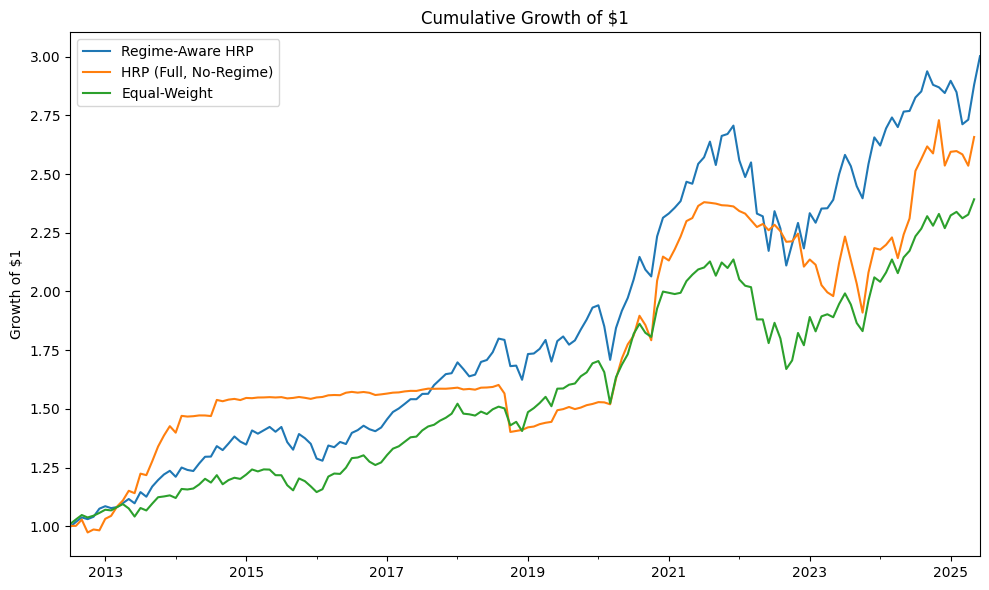

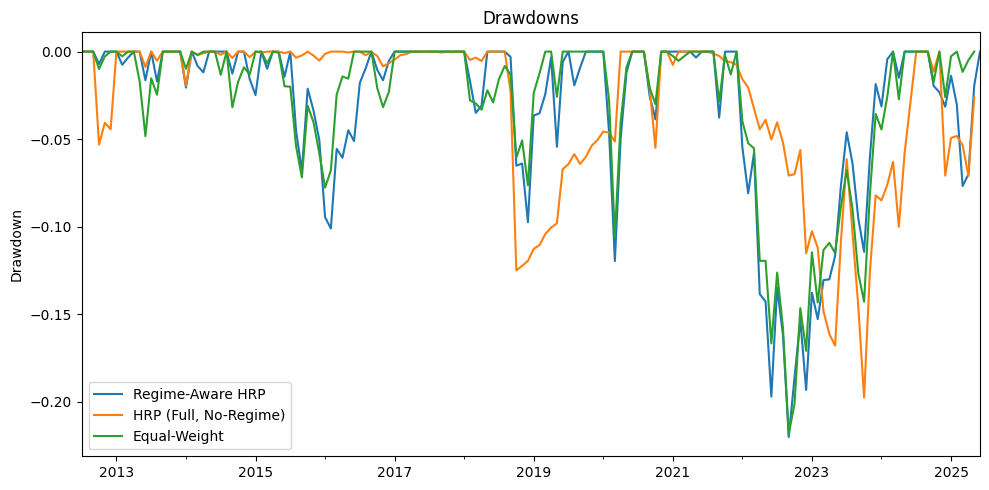

In [20]:
# === Plot cumulative oos returns ===
cum = (1 + all_rets[order]).cumprod()
cum.plot(figsize=(10,6), title='Cumulative Growth of $1')
plt.ylabel('Growth of $1')
plt.tight_layout()
plt.show()

# Drawdown plot
dd = cum / cum.cummax() - 1
dd.plot(figsize=(10,5), title='Drawdowns')
plt.ylabel('Drawdown')
plt.tight_layout()
plt.show()


Turnover diagnostics.


In [21]:
# === Turnover diagnostics ===
to_regime  = turnover(weights_regime,  asset_ret_m)
to_hrp_full = turnover(weights_hrp_full, asset_ret_m)
to_eq      = turnover(weights_eq,      asset_ret_m)

pd.Series({
    'Turnover - Regime-Aware HRP': to_regime,
    'Turnover - HRP (Full, No-Regime)': to_hrp_full,
    'Turnover - Equal-Weight': to_eq,
}).to_frame('Avg Monthly Turnover').style.format('{:.2%}')


,Avg Monthly Turnover
Turnover - Regime-Aware HRP,35.41%
"Turnover - HRP (Full, No-Regime)",44.21%
Turnover - Equal-Weight,2.17%


Regime probability timeline.


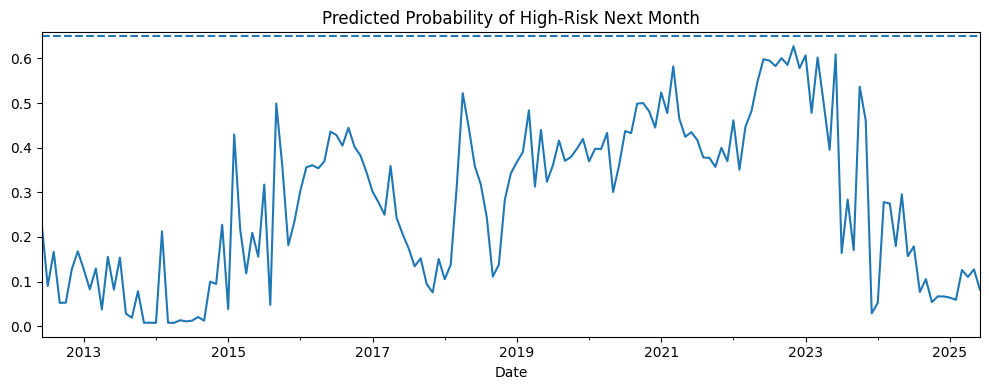

,Pr_HighRisk_next,HighRisk_flag,Pr_smooth
Date,,,
2025-02-28,0.059063,0,0.076921
2025-03-31,0.125946,0,0.091628
2025-04-30,0.110491,0,0.097287
2025-05-31,0.127387,0,0.106317
2025-06-30,0.081436,0,0.098853


In [22]:
# === Regime probability timeline ===
pred_df['Pr_HighRisk_next'].plot(figsize=(10,4), title='Predicted Probability of High‑Risk Next Month')
plt.axhline(RISK_PROB_ENTER, linestyle='--')
plt.tight_layout()
plt.show()

pred_df.tail()


I noticed the plot looks a bit off for HRP during 2014 - 2018 -> HRP seems flat during 2014 - end of 2018, why?

Average HRP (Full) weights 2014–2018:
 SHY   0.866563
IWM   0.055008
SPY   0.024709
QQQ   0.020776
EFA   0.009169
LQD   0.007639
TLT   0.007295
GLD   0.004015
EEM   0.003615
HYG   0.001211
dtype: float64

Avg monthly turnover 2014–2018: 0.17887735928245532

Corr to SHY: 0.10, TLT: 0.25, SPY: 0.42


<Axes: title={'center': 'HRP (Full) Weights 2014–2018'}>

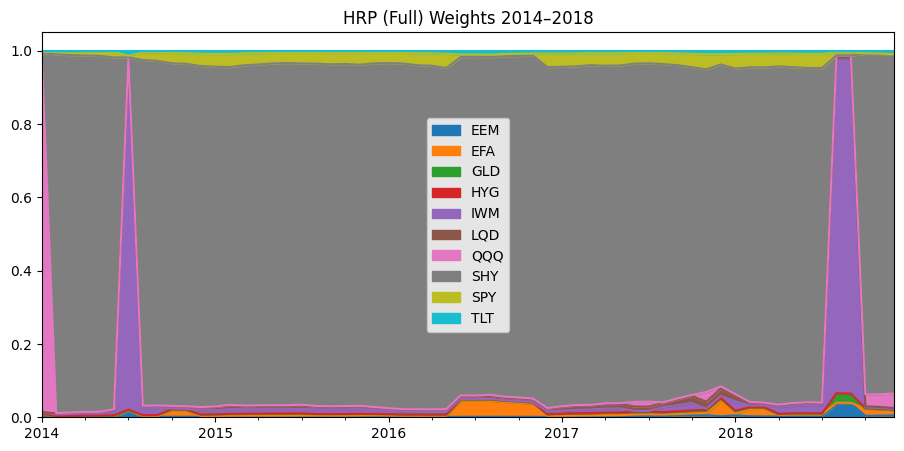

In [23]:
# Slice the period
mask = (weights_hrp_full.index >= '2014-01-31') & (weights_hrp_full.index <= '2018-12-31')
w14_18 = weights_hrp_full.loc[mask]

# Average weights (which assets dominate?)
avg_w = w14_18.mean().sort_values(ascending=False)
print("Average HRP (Full) weights 2014–2018:\n", avg_w)

# How active are the weights?
print("\nAvg monthly turnover 2014–2018:",
      w14_18.diff().abs().sum(axis=1).mean())

# Is the return stream bond-like?
corr_shy = ret_hrp_full.loc[w14_18.index].corr(asset_ret_m['SHY'].loc[w14_18.index])
corr_tlt = ret_hrp_full.loc[w14_18.index].corr(asset_ret_m['TLT'].loc[w14_18.index])
corr_eq  = ret_hrp_full.loc[w14_18.index].corr(asset_ret_m['SPY'].loc[w14_18.index])
print(f"\nCorr to SHY: {corr_shy:.2f}, TLT: {corr_tlt:.2f}, SPY: {corr_eq:.2f}")

# Visual check: weight stack
w14_18.plot.area(figsize=(11,5), title='HRP (Full) Weights 2014–2018')


### A few last words on what this project does well, and what to keep in mind

- Clean walk-forward design with lagged features and out-of-sample evaluation.
- Sensible risk plumbing: HRP with Ledoit–Wolf shrinkage, Spearman correlation in high-risk, plus volatility targets and exposure caps.
- Simple switching rule to reduce flip-flopping: go to high-risk only if the model’s probability is at least 0.65, and switch back to low-risk only if it drops below 0.35.
- Clear comparison against HRP (no regime) and Equal-Weight, with drawdowns, turnover, and a regime-probability timeline.


However, some points have to be considered:
- **Tuned by hand:** Top-30% label, 0.65/0.35 hysteresis, 50% cap, and 10%/5% vol targets are ad-hoc; no sensitivity bands shown.
- **Expanding-window drift:** Older data may dominate; model can under-react to fresh regime shifts.
- **Noisy risk inputs:** Spearman corr in high-risk + few monthly samples → jittery clusters/weights even with shrinkage.
- **Floors + smoothing:** Lower turnover, but hidden, persistent tilts can creep in and aren’t audited.
- **Thin costs & plumbing:** Simple bps/slippage and EOM alignment with forward-fills can understate frictions and blur shocks.
- **Validation gap:** Lacks parameter sweeps, naive baselines, and uncertainty bands to prove robustness.

To conclude, the regime-aware HRP delivered higher returns and stronger risk-adjusted performance (Sharpe 0.63, Sortino 0.94) than both HRP (no-regime) and Equal-Weight, with a similar Calmar ratio. However, tail risk and peak-to-trough drawdown were not strictly improved (slightly larger Max DD and ES 95%), so the benefit stems more from steadier month-to-month efficiency than from uniformly lower downside.



